In [ ]:
#Mask R-CNN GitHub Repository
!pip install mrcnn

#Use these specific versions otherwise problems arises
!pip install keras==2.2.5 
!pip install tensorflow-gpu==1.15.4


import sys
import time 
import tensorflow as tf
import os
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from mrcnn import visualize
import random
import cv2

import random
import itertools
import colorsys

#Load pretrained weights 
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 &>/dev/null

#Load trained weigths
!wget -O trained_weight https://www.dropbox.com/sh/yfns1nj9k5ksmc4/AAAsoPd8VHUmE04bSGu3xZjwa?dl=0
!unzip trained_weight
!rm trained_weight

#Load videos 
!wget -O fences https://www.dropbox.com/sh/elcjipz6vb651nk/AACdPipBvxnc-IfqEALbF20aa?dl=0
!unzip -q fences
!rm fences

--2020-12-20 15:52:23--  https://www.dropbox.com/sh/yfns1nj9k5ksmc4/AAAsoPd8VHUmE04bSGu3xZjwa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/yfns1nj9k5ksmc4/AAAsoPd8VHUmE04bSGu3xZjwa [following]
--2020-12-20 15:52:23--  https://www.dropbox.com/sh/raw/yfns1nj9k5ksmc4/AAAsoPd8VHUmE04bSGu3xZjwa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc30df20a9b59fc440b9452f42f7.dl.dropboxusercontent.com/zip_download_get/Ao3Nx_npU_AUGPbgJYqKOqL3PSC_tkoeN9t0UDTzXKbb_i_ptXm_3BvTiJjxsiKrTxn38FxzCp-PnPsUL5wSHonwEFz813-2C_hWA8ojlcLBqg [following]
--2020-12-20 15:52:24--  https://uc30df20a9b59fc440b9452f42f7.dl.dropboxusercontent.com/zip_download_get/Ao3Nx_npU_AUGPbgJYqKOqL3PSC_tkoeN9t0UDTzXKbb_i_ptXm_3BvTiJjxsiKrTxn38FxzCp-PnPsUL

'\n#Load videos \n!wget -O fences https://www.dropbox.com/sh/elcjipz6vb651nk/AACdPipBvxnc-IfqEALbF20aa?dl=0\n!unzip -q fences\n!rm fences\n'

In [ ]:
##Weights and images are currently on dropbox. These might be removed hoever. Use the script for data augmentation 
##creation instead along with the 465 original images given on github 

#Load small dataset 
!wget -O fences https://www.dropbox.com/sh/stu84velgd8kxxj/AAAh6d91HK3CTtUPZEAIecNca?dl=0
!unzip -q fences
!rm fences

#Load big dataset almost 7000 images 
!wget -O fences https://www.dropbox.com/sh/t18fsl6p8hhgcgl/AADHZzMB8Ha009R6hb96Voqsa?dl=0
!unzip -q fences
!rm fences

!wget -O fences https://www.dropbox.com/sh/bvkr0nljaolr1qx/AAA6ht2hV5wuS0gQMq3LqTeYa?dl=0
!unzip -q fences
!rm fences

!wget -O fences https://www.dropbox.com/sh/zz05cvnrvnw1w7i/AACPYhetF1cUvcTqGLWFZ4uma?dl=0
!unzip -q fences
!rm fences

!mkdir -p fences_augmented/annotations
!mkdir -p fences_augmented/images

!rsync -auv  big_data1/annotations/* fences_augmented/annotations/ &>/dev/null
!rsync -auv  big_data2/annotations/* fences_augmented/annotations/ &>/dev/null
!rsync -auv  big_data3/annotations/* fences_augmented/annotations/ &>/dev/null

!rsync -auv  big_data1/images/* fences_augmented/images/ &>/dev/null
!rsync -auv  big_data2/images/* fences_augmented/images/ &>/dev/null
!rsync -auv  big_data3/images/* fences_augmented/images/ &>/dev/null

!rm -r big_data1 big_data2 big_data3


--2020-12-20 15:13:59--  https://www.dropbox.com/sh/t18fsl6p8hhgcgl/AADHZzMB8Ha009R6hb96Voqsa?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/t18fsl6p8hhgcgl/AADHZzMB8Ha009R6hb96Voqsa [following]
--2020-12-20 15:14:00--  https://www.dropbox.com/sh/raw/t18fsl6p8hhgcgl/AADHZzMB8Ha009R6hb96Voqsa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2003633f99b00a658da9628bdb.dl.dropboxusercontent.com/zip_download_get/Ao2IBi6bsoKpaKUBHtdTIMrv7K0WF0s-Q-h5YZ_2_y_ksKDvBqvXIR9p4IWQMBR-CMtx0GDerf2lHglHPMmmIjClQ20gqwDIgb-lE6DpsNlx2w [following]
--2020-12-20 15:14:02--  https://uc2003633f99b00a658da9628bdb.dl.dropboxusercontent.com/zip_download_get/Ao2IBi6bsoKpaKUBHtdTIMrv7K0WF0s-Q-h5YZ_2_y_ksKDvBqvXIR9p4IWQMBR-CMtx0GDerf2lHglHP

Train: 5580


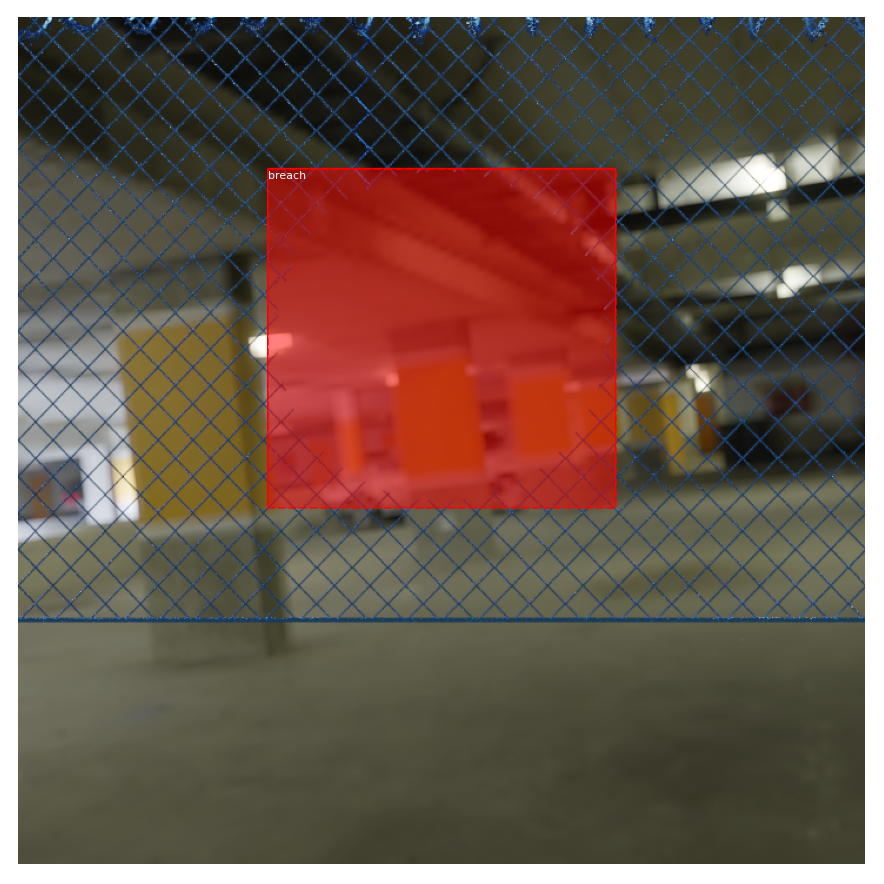

In [ ]:
##Inspirations has been taken from https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/
##Initial setup of the network

dataset_name = 'fences_augmented'
#dataset_name = "small_dataset_fences"

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

class fenceDataset(Dataset):
  def load_dataset(self,dataset_dir,is_train=True):
    self.add_class("dataset", 1, "breach")
    images_dir = dataset_dir + '/images/'
    annotations_dir = dataset_dir + '/annotations/'
    for filename in filelist(annotations_dir,'xml'):

      root = ElementTree.parse(filename).getroot()
      image_id = int(root.find('.//id').text)

			#Make 80% of images as training set (>=5580) >=(372)
      if is_train and int(image_id) >= 5580:
        continue
			#Make 20% as validation/test set (<5580) <(372)
      if not is_train and int(image_id) < 5580:
        continue
      img_path = images_dir + '/image' + str(image_id) + '.png'
      ann_path = filename #annotations_dir + str(image_id) + '.xml'
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
 
  def extract_boxes(self, filename):
		
    tree = ElementTree.parse(filename)
    root = tree.getroot()
    boxes = list()
    for box in root.findall('.//bndbox'):
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      coors = [xmin, ymin, xmax, ymax]
      boxes.append(coors)
    width = int(root.find('.//size/width').text)
    height = int(root.find('.//size/height').text)
    return boxes, width, height
    
  def load_mask(self, image_id):
    
    info = self.image_info[image_id]
    path = info['annotation']
    boxes, w, h = self.extract_boxes(path)
    masks = zeros([h, w, len(boxes)], dtype='uint8')
    class_ids = list()

    for i in range(len(boxes)):
      box = boxes[i]
      row_s, row_e = box[1], box[3]
      col_s, col_e = box[0], box[2]
      masks[row_s:row_e, col_s:col_e, i] = 1
      class_ids.append(self.class_names.index('breach'))
    return masks, asarray(class_ids, dtype='int32')
    
  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']


class fenceConfig(Config):
  NAME = "fence_cfg"
  NUM_CLASSES = 1 + 1
  STEPS_PER_EPOCH = 100
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7


class PredictionConfig(Config):
  NAME = "fence_cfg"
  NUM_CLASSES = 1 + 1
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7
 

def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    #Convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    #Convert image into one sample
    sample = expand_dims(scaled_image, 0)
    #Make prediction
    yhat = model.detect(sample, verbose=0)
    #Extract results for first sample
    r = yhat[0]
    #Calculate statistics, including mean average presicion (mAP)
    AP, precisions, recalls, overlaps = new_compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    #Because the algorithm sometime returns 'nan'
    if not math.isnan(AP):
      APs.append(AP)
  #Calculate the mean AP across all images
  mAP = mean(APs)
  return mAP

train_set = fenceDataset()
train_set.load_dataset(dataset_name, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

image_id = 0
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)

display_instances(image, bbox, mask, class_ids, train_set.class_names)


In [ ]:
#Train the network giving a dataset
train_set = fenceDataset()
train_set.load_dataset(dataset_name, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
 
test_set = fenceDataset()
test_set.load_dataset(dataset_name, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

config = fenceConfig()
cfg  = PredictionConfig()

model = MaskRCNN(mode='training', model_dir='./', config=config)
model_inference = MaskRCNN(mode='training', model_dir='./', config=cfg )

model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

#Now redirect stdout to file for plotting
stdout = sys.stdout

sys.stdout = open('loses_outputs' + str(current_time) + '.txt', 'w')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=50, layers='all')

#Redirect stdout back
sys.stdout = stdout


Train: 372
Test: 93






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead









/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


[[1.6428, 0.0142, 0.2268, 0.1959, 0.5316, 0.6743, 0.9754, 0.0033, 0.1564, 0.0338, 0.24, 0.542], [0.9397, 0.007, 0.1208, 0.0367, 0.2266, 0.5486, 0.9545, 0.0052, 0.1339, 0.0572, 0.2117, 0.5466], [0.785, 0.0044, 0.114, 0.0334, 0.1475, 0.4855, 1.0691, 0.0064, 0.2209, 0.034, 0.1706, 0.6372], [0.8017, 0.0046, 0.077, 0.029, 0.1335, 0.5576, 0.7992, 0.0012, 0.103, 0.0236, 0.1384, 0.533], [0.8593, 0.0041, 0.1168, 0.0521, 0.1077, 0.5785, 0.8097, 0.0028, 0.0764, 0.0414, 0.1428, 0.5463], [0.8428, 0.0043, 0.0911, 0.0615, 0.1208, 0.5651, 0.8451, 0.0051, 0.1881, 0.0276, 0.0917, 0.5327], [0.7004, 0.0029, 0.0718, 0.0284, 0.0634, 0.5339, 0.7778, 0.0033, 0.1062, 0.0382, 0.1166, 0.5134], [0.6854, 0.0037, 0.0537, 0.0282, 0.0658, 0.5339, 0.7821, 0.0043, 0.1027, 0.0607, 0.1509, 0.4635], [0.7254, 0.003, 0.0883, 0.0334, 0.0874, 0.5134, 0.7358, 0.0036, 0.0657, 0.0384, 0.0949, 0.5331], [0.6114, 0.0019, 0.0449, 0.0277, 0.0367, 0.5002, 0.6259, 0.0015, 0.0443, 0.0203, 0.0501, 0.5097], [0.6969, 0.004, 0.0638, 0.0426,

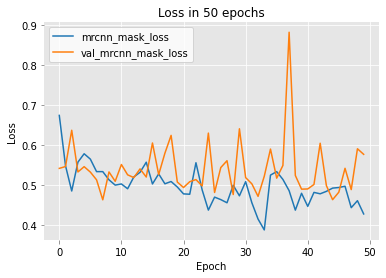

In [ ]:
#Read output from loses to make inference 
loss_names = ['loss', 'rpn_class_loss', 'rpn_bbox_loss', 'mrcnn_class_loss', 'mrcnn_bbox_loss',\
              'mrcnn_mask_loss','val_loss', 'val_rpn_class_loss', 'val_rpn_bbox_loss',\
              'val_mrcnn_class_loss', 'val_mrcnn_bbox_loss', 'val_mrcnn_mask_loss']
f = open('loses_outputs.txt','r')

lines = f.readlines()
loses = []

for i in lines:
  loss = []
  item = i.split()
  for index in range (len(item)):
    if item[0] == '100/100':
      if item[index] == "loss:":
        loss.append(float(item[index+1]))
      if item[index] == "rpn_class_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "rpn_bbox_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "mrcnn_class_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "mrcnn_bbox_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "mrcnn_mask_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "val_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "val_rpn_class_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "val_rpn_bbox_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "val_mrcnn_class_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "val_mrcnn_bbox_loss:":
        loss.append(float(item[index+1]))
      if item[index] == "val_mrcnn_mask_loss:":
        loss.append(float(item[index+1]))
  if len(loss):
    loses.append(loss)

print(loses)

#Print inference
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

loss_index = [5,11]

fig, ax = pyplot.subplots()
    

ax.set_axisbelow(True)
ax.set_facecolor('#E6E6E6')
pyplot.grid(color='w', linestyle='solid')

for spine in ax.spines.values():
    spine.set_visible(False)

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
  tick.set_color('black')
for tick in ax.get_yticklabels():
  tick.set_color('black')

epochs = range(len(loses))
ax.plot(epochs, [l[loss_index[0]] for l in loses],label=loss_names[loss_index[0]])
ax.plot(epochs, [l[loss_index[1]] for l in loses],label=loss_names[loss_index[1]])

ax.set_title("Loss in {} epochs".format(len(loses)))

ax.legend()

pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.savefig(str(current_time) + '.png')



In [ ]:
!rm -r fence_cfg20201220T1349/ fence_cfg20201220T1359/ fence_cfg20201220T1409/ fence_cfg20201220T1422/

In [ ]:
#Evaluate the mask-rcnn to find the mAP
train_set = fenceDataset()
train_set.load_dataset(dataset_name, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

test_set = fenceDataset()
test_set.load_dataset(dataset_name, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

sess = tf.Session()
file_writer = tf.summary.FileWriter('./', sess.graph)

cfg = PredictionConfig()

model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

path = "trained_weights/mask_rcnn_fence_cfg_0050_small_all.h5"
#path = "fence_cfg20201220T1217/mask_rcnn_fence_cfg_0050.h5"
model.load_weights(path, by_name=True)

train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)

test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train: 5580
Test: 1339
1.0
0.0
1.0
0.6666666865348816
0.0
1.0
0.6666666865348816
1.0
0.0
0.0
0.5666666666666667
1.0
0.5
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.3333333333333333
1.0
0.3333333432674408
1.0
1.0
1.0
0.0833333358168602
1.0
0.0
0.0
0.9523809552192688
1.0
0.0
1.0
1.0
0.6666666865348816
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.5
0.5000000149011612
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
0.8333333333333333
0.0
0.0
0.0
0.0
1.0
0.5
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.3333333432674408


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.5
0.0
1.0
0.5
0.6666666865348816
1.0
1.0
1.0
0.3333333432674408
1.0
1.0
0.0
0.6666666865348816
1.0
0.0
0.5
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.625
0.0
1.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
0.375
1.0
0.5
0.5
1.0
1.0
0.5
0.0
1.0
0.3333333432674408
0.75
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.3333333432674408
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.0
1.0
0.5
0.0
1.0
1.0
0.2222222288449605
0.0
1.0
1.0
1.0
0.1666666716337204
1.0
0.0
1.0
0.0
0.6666666865348816
1.0
1.0
0.6666666865348816
1.0
1.0
0.0
0.5
1.0
1.0
1.0
1.0
1.0
0.6875
1.0
1.0
0.0
0.3333333432674408
0.6666666865348816
1.0
0.6666666666666666
0.5
1.0
1.0
1.0
1.0
0.0
0.5
0.6666666865348816
1.0
0.0
1.0
0.6666666865348816


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
0.8333333134651184
1.0
1.0
1.0
0.8333333333333333
1.0
0.0
0.0
0.0
1.0
0.25
1.0
0.6666666865348816
1.0
1.0
0.6666666865348816
1.0
0.3
1.0
0.5
0.0
0.800000011920929
1.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
0.25
1.0
1.0
1.0
0.5
1.0
0.25
0.25
0.0
1.0
0.75
1.0
1.0
0.0
1.0
0.5
1.0
1.0
0.0
1.0
0.5
1.0
1.0
0.5
0.6666666865348816


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.5
1.0
0.5
1.0
1.0
1.0
1.0
0.3333333432674408
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.5
1.0
0.0
0.0
1.0
0.6666666865348816
0.5
0.0
0.0
0.6666666865348816
0.0
1.0
1.0
0.0
0.5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
0.6666666865348816


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.1666666716337204
0.5
0.0
1.0
0.625
0.5
0.5
0.5
0.8333333134651184
1.0
1.0
1.0
1.0
0.0
1.0
0.1666666716337204
1.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
0.6666666865348816
1.0
0.0
1.0
1.0
1.0
0.0
0.8333333134651184
1.0
0.5
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.6666666865348816
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.6666666865348816
1.0
0.5
1.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.25
1.0
1.0
0.5
1.0
0.0
0.5
1.0
0.5
1.0
0.75
0.25
0.4000000059604645
1.0
0.9761904733521598
1.0
1.0
0.9166666716337204
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.6666666865348816
1.0
0.5
0.6666666865348816
0.0
0.0
0.0
0.6000000178813935
0.6666666865348816
0.3333333432674408
1.0
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
1.0
0.0
0.0
0.6666666666666666
0.6666666865348816
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8333333134651184
1.0
1.0
1.0
1.0
1.0
1.0
0.5
1.0
1.0
1.0
1.0
1.0
1.0
0.3333333432674408
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.8333333134651184
1.0
0.5555555721124013
1.0
0.0
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.5
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.6666666865348816
0.041666666666666664
0.5
1.0
1.0
0.5
1.0
0.6666666865348816
0.55
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.6666666865348816
1.0
1.0
0.0
1.0
0.25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.3333333432674408
1.0
0.0
1.0
0.75
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.3666666686534882
0.0
0.0
1.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
0.3333333432674408
1.0
1.0
1.0
1.0
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
1.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.8333333333333333
1.0
0.0
1.0
0.0
1.0
1.0
0.6666666865348816
0.5
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.8333333358168602
0.75
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.3333333432674408
1.0
1.0
0.0
1.0
0.5
0.95
1.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.9761904733521598
0.8333333333333333
1.0
0.0
0.0
0.0
1.0
1.0
0.75
0.3333333432674408
0.0
1.0
0.5
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.6666666716337204


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.5
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.6875
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.6666666865348816
1.0
1.0
0.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
0.0
1.0
0.5
0.0
1.0
0.0
1.0
1.0
1.0
1.0
0.6666666865348816
0.0
1.0
1.0
1.0
0.25
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8333333134651184
0.0
1.0
0.6666666865348816
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.625
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.6666666865348816
0.0
1.0
1.0
0.6666666865348816
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.3333333432674408
0.75
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.6666666865348816
1.0
1.0
1.0
0.0
1.0
0.6666666666666666
1.0
1.0
0.6666666865348816
1.0
1.0
1.0
0.0
1.0
0.6
0.0
0.0
0.7777777612209321
1.0
0.6666666666666666
1.0
0.3333333432674408
0.5
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
0.5
0.6666666865348816
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
0.6666666865348816
1.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.3333333432674408
1.0
1.0
1.0
1.0
0.8333333333333333
1.0
1.0
0.0
1.0
0.5
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
1.0
1.0
0.75
0.0
1.0
0.6666666865348816
0.3333333432674408
0.0
0.75
0.0
0.0
1.0
1.0
1.0
1.0
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.5
0.0
0.0
1.0
1.0
1.0
0.6666666865348816
1.0
1.0
1.0
1.0
0.5555555721124014
0.6666666865348816
0.5
1.0
1.0
1.0
1.0
0.6666666865348816
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.3333333432674408
0.6666666865348816
1.0
1.0
0.6666666865348816
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.0
1.0
0.6666666865348816
0.0
0.3333333432674408
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.5
1.0
1.0
0.4000000059604645
0.0
0.0
1.0
0.6666666865348816
1.0
1.0
0.0
1.0
1.0
0.6666666865348816
1.0
1.0
0.1666666716337204
1.0
1.0
0.9166666716337204
1.0
0.8333333333333333
1.0
0.0
0.95
1.0
0.0
1.0
0.0
1.0
1.0
1.0
0.0
0.5
1.0
0.0
0.3333333432674408
0.0
0.3333333432674408
1.0
1.0
0.0
0.0
0.0
0.5
0.5
0.0
0.0
1.0
0.5
0.5
0.5
0.0
1.0
1.0
0.0
0.6800000101327897
0.1666666716337204
1.0
1.0
0.6666666865348816
1.0
0.25
0.0
0.0
0.8333333358168602
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.8333333333333333
1.0
1.0
1.0
0.5000000149011612
0.3333333432674408
1.0
0.800000011920929
1.0
1.0
1.0
0.6666666865348816
1.0
1.0
1.0
0.3333333432674408
0.0
1.0
0.8333333134651184
0.0
1.0
1.0
0.0
0.0
0.0
0.5
1.0
1.0
0.5
0.0
0.5625
0.0
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
0.6666666865348816
0.25
0.5555555721124013
1.0
0.0
0.6666666865348816
1.0
1.0
0.5
0.6666666865348816
0.5
0.0
1.0
1.0
1.0
1.0
1.0
0.6666666865348816
0.0
1.0
0.0
1.0
0.0
0.0
0.3333333432674408
1.0
0.6666666865348816
0.625
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
1.0
1.0
1.0
0.5
1.0
0.0
1.0
0.0
0.8333333333333333
1.0
1.0
1.0
1.0
0.6666666865348816
1.0
1.0
1.0
0.5
1.0
1.0
1.0
0.5
1.0
0.0
1.0
1.0
0.0
0.5
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.6666666865348816
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
0.0
0.5
1.0
0.0
0.6666666865348816
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.5
0.0
0.0
0.0
1.0
0.0
0.5
0.0
1.0
0.3333333432674408
0.6333333492279053
0.8333333134651184
0.5
0.0
1.0
0.0
0.6666666865348816
1.0
1.0
1.0
1.0
0.5
1.0
1.0
1.0
0.6666666865348816
0.0
1.0
1.0
0.0
0.3333333432674408
0.0
1.0
1.0
0.6666666865348816
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
0.0
0.6875
0.5
0.25
0.0
0.0
0.0
0.75
0.5
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
1.0
1.0
1.0
1.0
0.0
1.0
0.6666666865348816
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.6666666865348816
1.0
0.8666666746139526
0.25
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
1.0
1.0
0.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
1.0
0.0
1.0
1.0
0.6666666865348816
1.0
0.0
1.0
0.0
0.0
1.0
0.3333333432674408
0.5
0.5
0.5
1.0
1.0
0.0
1.0
1.0
0.6666666865348816
0.75
1.0
0.0
1.0
1.0
0.5
0.6800000101327897
0.8333333333333333
0.0
1.0
1.0
0.0
1.0
0.8333333333333333
0.3333333432674408
0.0
1.0
0.0
0.0
1.0
1.0
0.6666666865348816
0.6666666865348816
1.0
0.6666666865348816
1.0
1.0
1.0
1.0
1.0
0.1666666716337204
0.0
0.5
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.6666666865348816
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
1.0
0.0
0.3333333432674408
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
1.0
0.6666666865348816
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.6666666865348816
1.0
1.0
1.0
0.5
1.0
1.0
0.0
0.0
0.75
1.0
0.9166666716337204
0.0
1.0
1.0
0.8333333134651184
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.5
0.6666666865348816
1.0
0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.8333333333333333
0.75
1.0
0.0
0.08333333333333333
0.6666666865348816
0.0
1.0
1.0
1.0
1.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:686: RuntimeWarning: invalid value encountered in true_divide


nan
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Test mAP: 0.660


In [ ]:
#Load images from video 
!rm -r video_fences/data/trial1/
!mkdir -p video_fences/data/trial1/
!mkdir -p video_fences/data/rois_images
path_in = "video_fences/test2.mp4"
path_out = "video_fences/data/trial1/"

#Make dataset for test from video 
class fenceDataset(Dataset):
  def load_dataset(self,dataset_dir,is_train=True):
    self.add_class("dataset", 1, "breach")
    
    count = 0
    vidcap = cv2.VideoCapture(path_in)
    success, image = vidcap.read()
    success = True

    while success:
      vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*1000)) 
      success, image = vidcap.read()
      if success:
        img_path = path_out + "image%d.png" % count
        cv2.imwrite(img_path, image)
        self.add_image('dataset', image_id=count, path=img_path)
        count = count + 1



rm: cannot remove 'video_fences/data/trial1/': No such file or directory


Train: 21
Test: 21
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.700

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


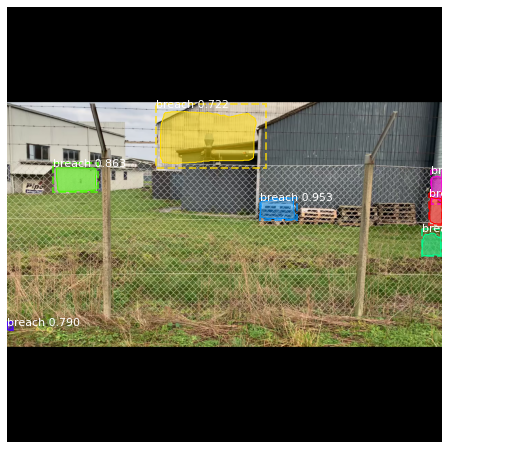

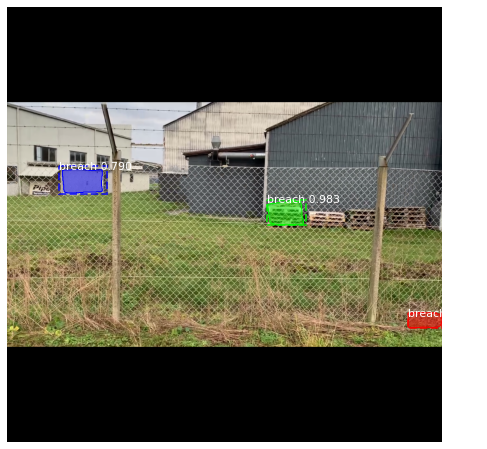

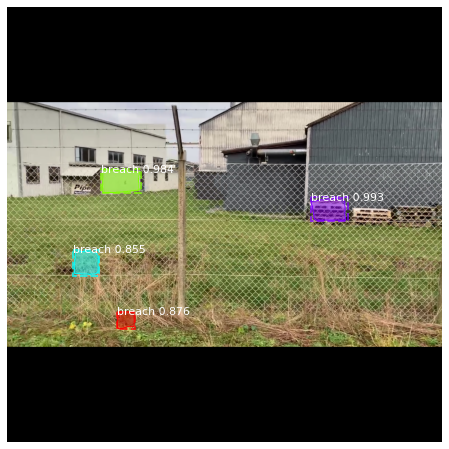

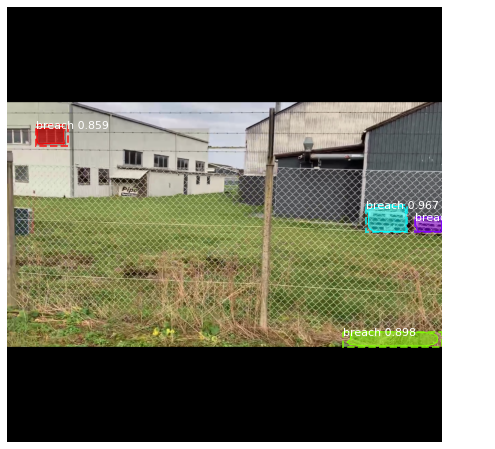

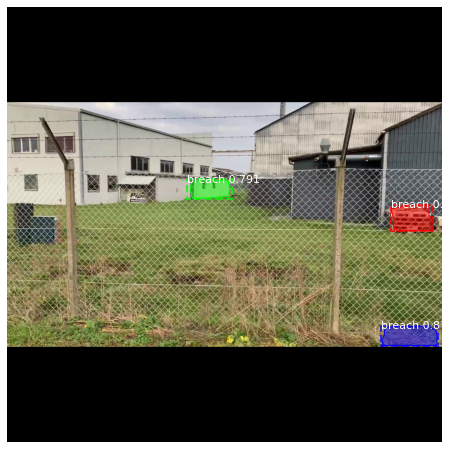

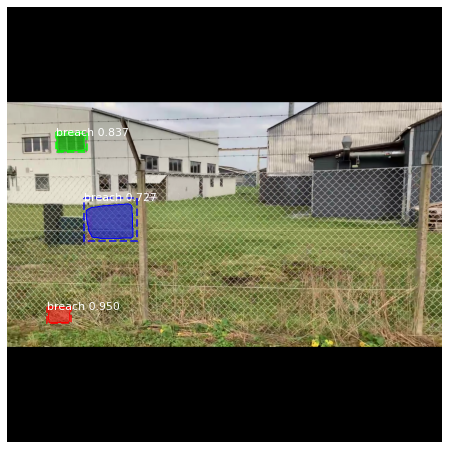

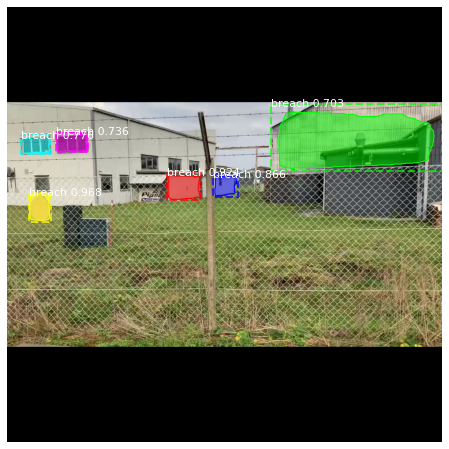

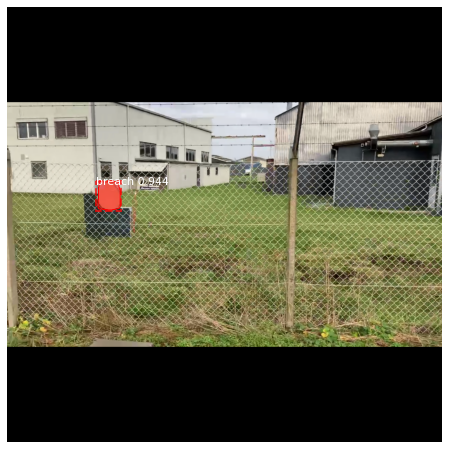

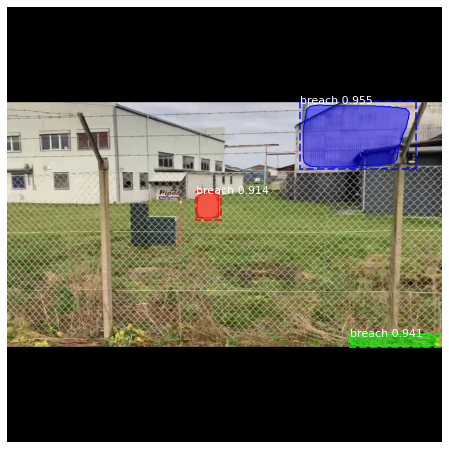

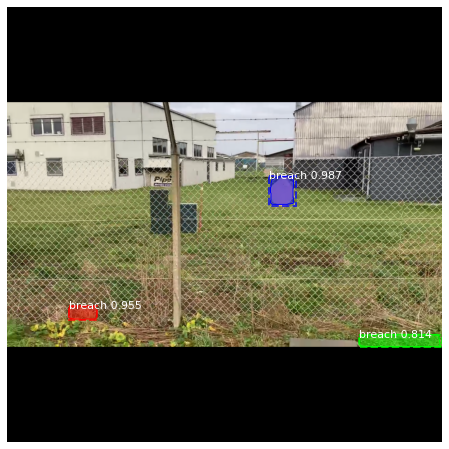

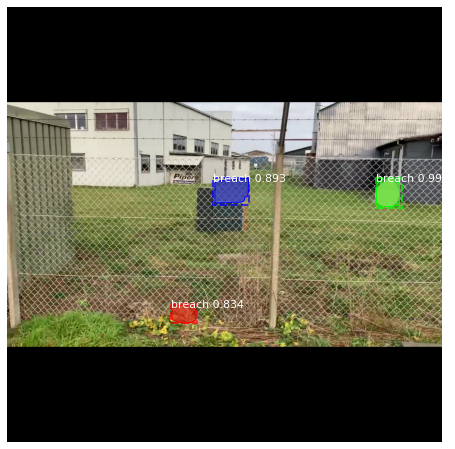

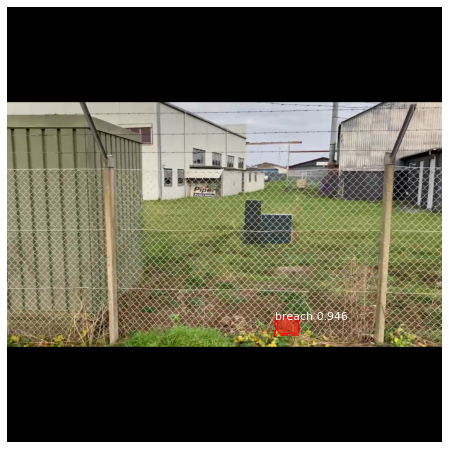

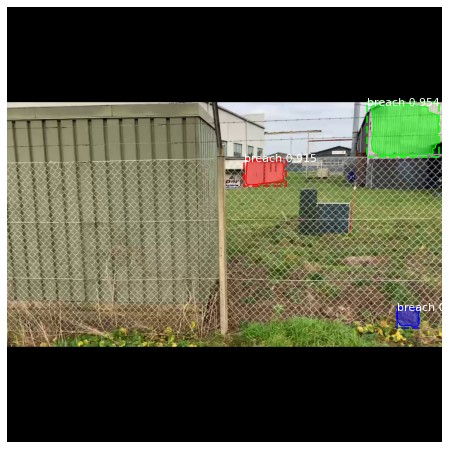

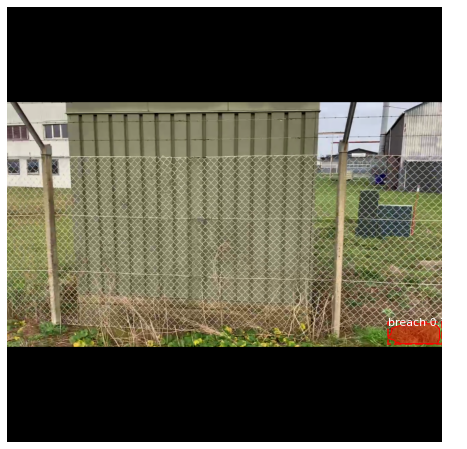

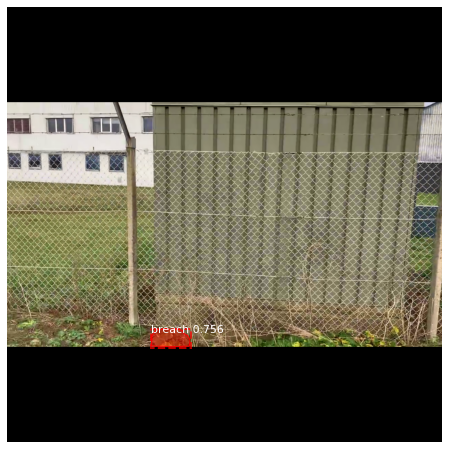

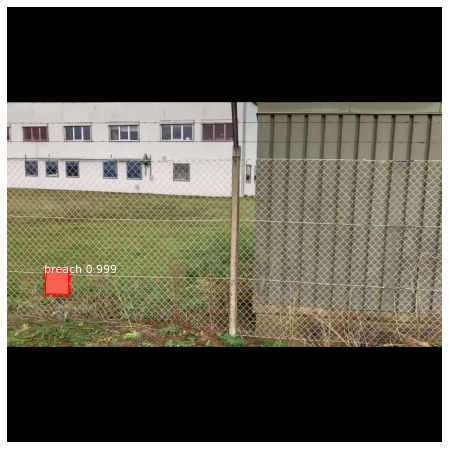

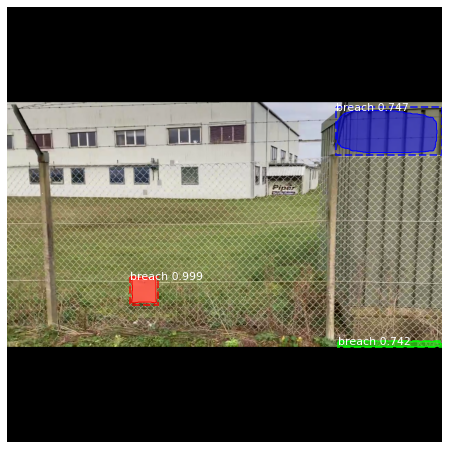

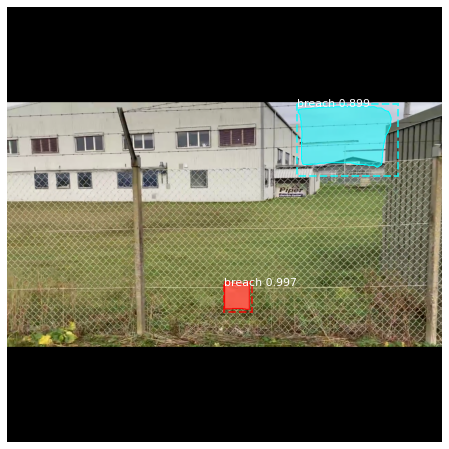

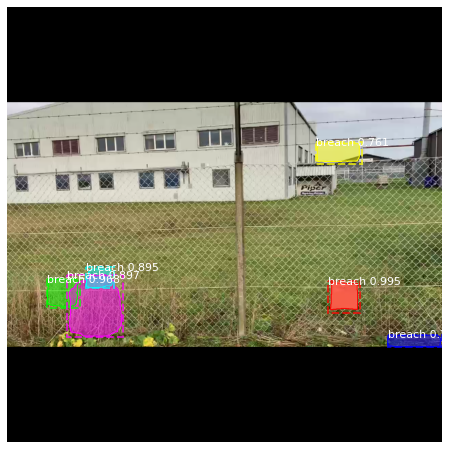

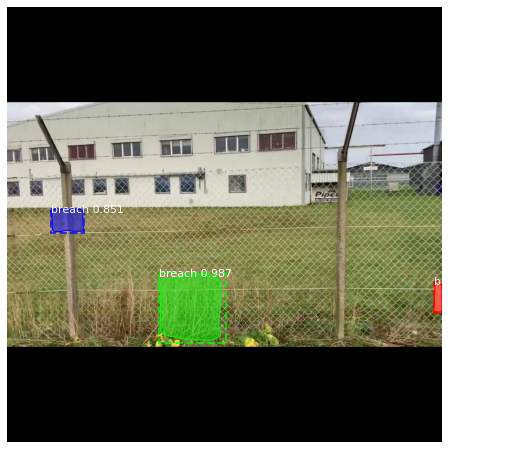

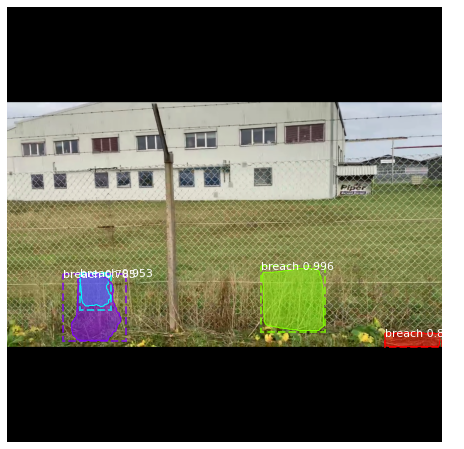

In [ ]:
#Detect breaches in the video (Final acceptence test)
train_set = fenceDataset()
train_set.load_dataset(dataset_name, is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

test_set = fenceDataset()
test_set.load_dataset(dataset_name, is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

config = fenceConfig()
cfg  = PredictionConfig()

model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
path = "trained_weights/mask_rcnn_fence_cfg_0050_all.h5"
model.load_weights(path, by_name=True)

def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

for i in range(len(test_set.image_ids)):
  image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(test_set, config, i, use_mini_mask=False)
  results = model.detect([image], verbose=1)
  r = results[0]
  display_instances(image, r['rois'], r['masks'], r['class_ids'],test_set.class_names, r['scores'], ax=get_ax())